In [1]:
from tensorflow.keras.layers import Input, LSTM, GRU,SimpleRNN, Dense, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



In [2]:
# Load the data

akbank_data = pd.read_csv("C:\\Users\\ERALP\\OneDrive\\Desktop\\Software Engineering\\SWE599---Financial-Time-Series-Volatility-and-Return-Forecasting\\Code\\akbank_data.csv")

akbank_data.head()


,Date,Hour,Open,High,Low,Close
0,12/2/2019,9:00:00,6.57,6.57,6.57,6.57
1,12/2/2019,10:00:00,6.57,6.59,6.51,6.52
2,12/2/2019,11:00:00,6.52,6.58,6.51,6.57
3,12/2/2019,12:00:00,6.57,6.57,6.46,6.48
4,12/2/2019,13:00:00,6.49,6.49,6.49,6.49


In [3]:
akbank_data.tail()

,Date,Hour,Open,High,Low,Close
9987,21/02/2023,17:00:00,16.12,16.14,15.80,15.92
9988,21/02/2023,18:00:00,15.90,15.90,15.90,15.90
9989,22/02/2023,9:00:00,15.89,15.89,15.89,15.89
9990,22/02/2023,10:00:00,15.88,16.23,15.82,16.13
9991,22/02/2023,11:00:00,16.13,16.29,16.09,16.17


In [4]:
akbank_data = akbank_data[['Date', 'Hour', 'Open', 'High', 'Low', 'Close']]

#Converting Date and Hour to datetime object and setting it as index. This will help us to plot the data in a time series manner.

akbank_data['Datetime'] = pd.to_datetime(akbank_data['Date'] + " " + akbank_data['Hour'])

#Dropping Date and Hour columns
akbank_data.set_index('Datetime', inplace=True)
akbank_data.drop(['Date', 'Hour'], axis=1, inplace=True)

akbank_data.head()

,Open,High,Low,Close
Datetime,,,,
2019-12-02 09:00:00,6.57,6.57,6.57,6.57
2019-12-02 10:00:00,6.57,6.59,6.51,6.52
2019-12-02 11:00:00,6.52,6.58,6.51,6.57
2019-12-02 12:00:00,6.57,6.57,6.46,6.48
2019-12-02 13:00:00,6.49,6.49,6.49,6.49


In [5]:
akbank_data.tail()

,Open,High,Low,Close
Datetime,,,,
2023-02-21 17:00:00,16.12,16.14,15.80,15.92
2023-02-21 18:00:00,15.90,15.90,15.90,15.90
2023-02-22 09:00:00,15.89,15.89,15.89,15.89
2023-02-22 10:00:00,15.88,16.23,15.82,16.13
2023-02-22 11:00:00,16.13,16.29,16.09,16.17


In [6]:
series = akbank_data['Close'].values.reshape(-1,1)

In [7]:
# Normalize the data

scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()



In [8]:
# Build the dataset
# Let's see if we can use T past values to predict the next value
# In other words, T past values -> single future value

T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)


X.shape (9982, 10, 1) Y.shape (9982,)


In [9]:
# Try autoregressive RNN model

i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# Train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
156/156 [==============================] - 4s 13ms/step - loss: 0.2425 - val_loss: 21.0611
Epoch 2/80
156/156 [==============================] - 1s 8ms/step - loss: 0.0546 - val_loss: 19.8933
Epoch 3/80
156/156 [==============================] - 1s 7ms/step - loss: 0.0240 - val_loss: 19.1220
Epoch 4/80
156/156 [==============================] - 1s 7ms/step - loss: 0.0107 - val_loss: 18.6155
Epoch 5/80
156/156 [==============================] - 1s 7ms/step - loss: 0.0071 - val_loss: 18.3109
Epoch 6/80
156/156 [==============================] - 1s 7ms/step - loss: 0.0059 - val_loss: 18.0873
Epoch 7/80
156/156 [==============================] - 1s 7ms/step - loss: 0.0053 - val_loss: 17.9208
Epoch 8/80
156/156 [==============================] - 1s 7ms/step - loss: 0.0048 - val_loss: 17.7660
Epoch 9/80
156/156 [==============================] - 1s 7ms/step - loss: 0.0045 - val_loss: 17.6346
Epoch 10/80
156/156 [==============================] - 1s 7ms/step - loss: 0.0042 - val_lo

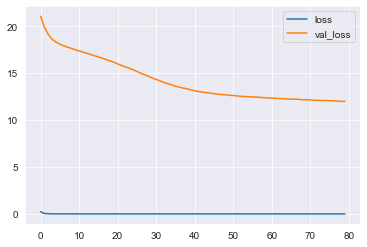

In [10]:
# Plot loss per iteration

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

312/312 [==============================] - 1s 2ms/step
(9982, 1)


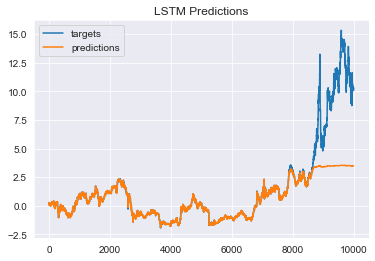

In [11]:
# One-step forecast using true targets

# Note: even the one-step forecast fails badly

outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("LSTM Predictions")
plt.legend()
plt.show()

1/1 [==============================] - 0s 30ms/step


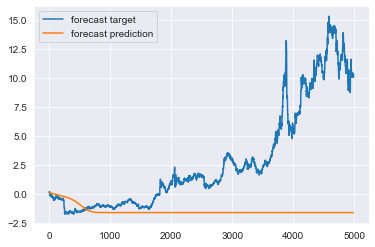

In [12]:
# Multi-step forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()



In [13]:
akbank_data['PrevClose'] = akbank_data['Close'].shift(1)

In [14]:
akbank_data.head()

,Open,High,Low,Close,PrevClose
Datetime,,,,,
2019-12-02 09:00:00,6.57,6.57,6.57,6.57,NaN
2019-12-02 10:00:00,6.57,6.59,6.51,6.52,6.57
2019-12-02 11:00:00,6.52,6.58,6.51,6.57,6.52
2019-12-02 12:00:00,6.57,6.57,6.46,6.48,6.57
2019-12-02 13:00:00,6.49,6.49,6.49,6.49,6.48


In [15]:
# return is 

akbank_data['Return']= (akbank_data['Close']- akbank_data['PrevClose']) / akbank_data['PrevClose']

In [16]:
akbank_data.head()

,Open,High,Low,Close,PrevClose,Return
Datetime,,,,,,
2019-12-02 09:00:00,6.57,6.57,6.57,6.57,NaN,NaN
2019-12-02 10:00:00,6.57,6.59,6.51,6.52,6.57,-0.007610
2019-12-02 11:00:00,6.52,6.58,6.51,6.57,6.52,0.007669
2019-12-02 12:00:00,6.57,6.57,6.46,6.48,6.57,-0.013699
2019-12-02 13:00:00,6.49,6.49,6.49,6.49,6.48,0.001543


<AxesSubplot:>

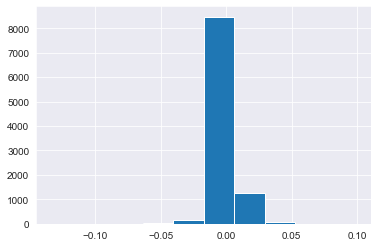

In [17]:
akbank_data['Return'].hist()

In [18]:
series = akbank_data['Return'].values[1:].reshape(-1,1)

scaler = StandardScaler()
scaler.fit(series[:len(series)//2])
series = scaler.transform(series).flatten()

In [19]:
T = 10

In [20]:
akbank_data.head()

,Open,High,Low,Close,PrevClose,Return
Datetime,,,,,,
2019-12-02 09:00:00,6.57,6.57,6.57,6.57,NaN,NaN
2019-12-02 10:00:00,6.57,6.59,6.51,6.52,6.57,-0.007610
2019-12-02 11:00:00,6.52,6.58,6.51,6.57,6.52,0.007669
2019-12-02 12:00:00,6.57,6.57,6.46,6.48,6.57,-0.013699
2019-12-02 13:00:00,6.49,6.49,6.49,6.49,6.48,0.001543


<AxesSubplot:>

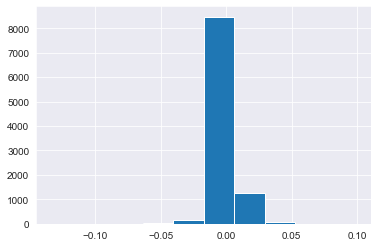

In [21]:
akbank_data['Return'].hist()

In [22]:
series = akbank_data['Return'].values[1:].reshape(-1,1)

scaler = StandardScaler()
scaler.fit(series[:len(series)//2])
series = scaler.transform(series).flatten()

In [23]:
T = 10
D= 1
X = []
Y = []

for t in range(len(series)-T):
    x= series[t:t+T]
    X.append(x)
    y= series[t-T]
    Y.appent(y)
    
X = np.array(X).reshape(-1,T,1)
Y = np.array(Y)
N= len(X)

print("")
